# Image Classification - Lab

## Introduction

Now that you have a working knowledge of CNNs and have practiced implementing associated techniques in Keras, its time to put all of those skills together. In this lab, you'll work to complete a Kaggle competition on classifying dog breeds.

https://www.kaggle.com/c/dog-breed-identification

## Objectives

You will be able to:
* Independently design and build a CNN for image classifcation tasks
* Compare and apply multiple techniques for tuning a model including data augmentation and adapting pretrained models

## Download and Load the Data

Start by downloading the data locally and loading it into a Pandas DataFrame. Be forewarened that this dataset is fairly large and it is advisable to close other memory intensive applications.

The data can be found here:

https://www.kaggle.com/c/dog-breed-identification/data

We recommend downloading the data into this directory on your local computer. From there, be sure to uncompress the folder and subfolders.

In [1]:
import datetime

t0 = datetime.datetime.now()

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
files = api.competition_download_files("dog-breed-identification")

In [4]:
import zipfile

os.mkdir('data/')
for file in os.listdir():
    if file[-4:] == '.zip':
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall(f'data/')
        zip_ref.close()
        os.remove(file)
        print(f'{file} Unzipped')

test.zip Unzipped
labels.csv.zip Unzipped
train.zip Unzipped
sample_submission.csv.zip Unzipped


In [5]:
len(os.listdir('data/train'))

10222

## Preprocessing

Now that you've downloaded the data, its time to prepare it for some model building! You'll notice that the current structure provided is not the same as our lovely preprocessed folders that we've been providing you. Instead, you have one large training folder with images and a csv file with labels associated with each of these file types. 

Use this to create a directory substructure for a train-validation-test split as we have done previously. Also recall from our previous work that you'll also want to use one-hot encoding as we are now presented with a multi-class problem as opposed to simple binary classification.

In [6]:
import pandas as pd
labels = pd.read_csv('data/labels.csv')
print(f'Total Breeds: {len(labels["breed"].value_counts())}')
print(f'Total Samples: {labels.shape[0]}')
labels.head()

Total Breeds: 120
Total Samples: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


We wish to create our standard directory structure:
* train
    * category1
    * category2
    * category3
    ...
* val
    * category1
    * category2
    * category3
    ...
* test 
    * category1
    * category2
    * category3
    ...  

In [7]:
# Create folders
os.mkdir('data_org')

for val in ['train', 'test', 'val']:
    os.mkdir(f'data_org/{val}')
    
    for breed in labels['breed'].unique():
        os.mkdir(f'data_org/{val}/{breed}')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(labels['id'], labels['breed'], test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
X_train[0] + '.jpg', y_train[0]

('dabb3c1034978cadfabf60eadcf08818.jpg', 'briard')

In [11]:
# Move files into appropriate folders based on splits
files_moved = 0
missed_files = 0

for i in range(len(X_train)):
    file = X_train[i] + '.jpg'
    breed = y_train[i]
    
    try:
        try:
            os.rename(f"data/train/{file}", f"data_org/train/{breed}/{file}")
            files_moved += 1
        except:
            os.rename(f"data/test/{file}", f"data_org/train/{breed}/{file}")
            files_moved += 1
    except:
        missed_files += 1
    
    
for i in range(len(X_val)):
    file = X_val[i] + '.jpg'
    breed = y_val[i]
    
    try:
        try:
            os.rename(f"data/train/{file}", f"data_org/val/{breed}/{file}")
            files_moved += 1
        except:
            os.rename(f"data/test/{file}", f"data_org/val/{breed}/{file}")
            files_moved += 1
    except:
        missed_files += 1
     
    
for i in range(len(X_test)):
    file = X_test[i] + '.jpg'
    breed = y_test[i]
    
    try:
        try:
            os.rename(f"data/train/{file}", f"data_org/test/{breed}/{file}")
            files_moved += 1
        except:
            os.rename(f"data/test/{file}", f"data_org/test/{breed}/{file}")
            files_moved += 1
    except:
        missed_files += 1
        
print(f'Files Moved: {files_moved}')
print(f'Files Missed: {missed_files}')

Files Moved: 10222
Files Missed: 0


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator().flow_from_directory('data_org/train/', 
                                                           target_size=(150, 150), 
                                                           batch_size=20, 
                                                           class_mode='categorical')

val_generator   = ImageDataGenerator().flow_from_directory('data_org/val/', 
                                                           target_size=(150, 150), 
                                                           batch_size=20, 
                                                           class_mode='categorical')

test_generator  = ImageDataGenerator().flow_from_directory('data_org/test/', 
                                                           target_size=(150, 150), 
                                                           batch_size=20, 
                                                           class_mode='categorical')

Using TensorFlow backend.


Found 6541 images belonging to 120 classes.
Found 1636 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [13]:
train_generator.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [15]:
imgs, labels = next(train_generator)

In [16]:
labels_dict = {}
for k in train_generator.class_indices.keys():
    labels_dict[train_generator.class_indices[k]] = k

In [17]:
breed_labels = [list(labels[i]).index(1) for i in range(len(labels))]

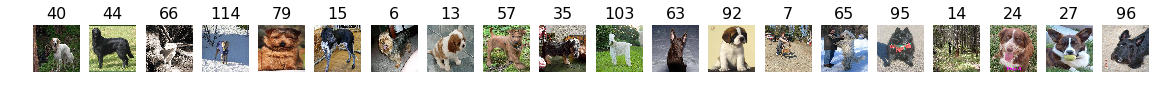

In [18]:
plots(imgs, figsize=(20, 10), titles=breed_labels)

## Optional: Build a Baseline CNN

This is an optional step. Adapting a pretrained model will produce better results, but it may be interesting to create a CNN from scratch as a baseline. If you wish to, do so here.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape = (150, 150, 3)), 
                    MaxPooling2D(strides=2, padding='same'), 
                    Conv2D(64, (3, 3), activation='relu'), 
                    MaxPooling2D(strides=2, padding='same'), 
                    Conv2D(128, (3, 3), activation='relu'), 
                    MaxPooling2D(strides=2, padding='same'),
                    Conv2D(128, (3, 3), activation='relu'), 
                    MaxPooling2D(strides=2, padding='same'),
                    Flatten(), 
                    Dense(64, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(512, activation='relu'),
                    Dense(120, activation='softmax')])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
model.compile(Adam(lr=.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=328, 
                              validation_data=val_generator, 
                              validation_steps=82, 
                              epochs=20, 
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 138s - loss: 4.8381 - acc: 0.0119 - val_loss: 4.7850 - val_acc: 0.0067
Epoch 2/20
 - 127s - loss: 4.7801 - acc: 0.0139 - val_loss: 4.7839 - val_acc: 0.0067
Epoch 3/20
 - 128s - loss: 4.7780 - acc: 0.0137 - val_loss: 4.7838 - val_acc: 0.0067
Epoch 4/20
 - 129s - loss: 4.7769 - acc: 0.0137 - val_loss: 4.7838 - val_acc: 0.0067
Epoch 5/20
 - 127s - loss: 4.7763 - acc: 0.0136 - val_loss: 4.7862 - val_acc: 0.0067
Epoch 6/20
 - 126s - loss: 4.7765 - acc: 0.0139 - val_loss: 4.7859 - val_acc: 0.0067
Epoch 7/20
 - 126s - loss: 4.7760 - acc: 0.0142 - val_loss: 4.7861 - val_acc: 0.0067
Epoch 8/20
 - 126s - loss: 4.7750 - acc: 0.0136 - val_loss: 4.7864 - val_acc: 0.0067
Epoch 9/20
 - 126s - loss: 4.7763 - acc: 0.0139 - val_loss: 4.7858 - val_acc: 0.0067
Epoch 10/20
 - 128s - loss: 4.7747 - acc: 0.0140 - val_loss: 4.7867 - val_acc: 0.0067
Epoch 11/20
 - 127s - loss: 4.7759 - acc: 0.0137 - val_loss: 4.7856 - val_acc: 0.0067
Epoch 12/20
 - 

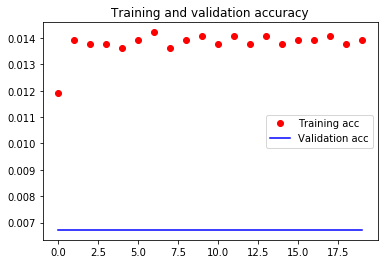

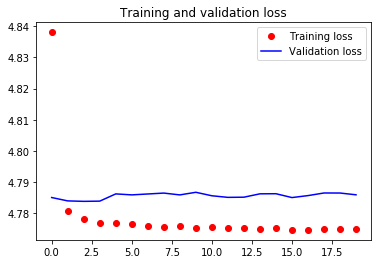

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 103)
y_hat_test = model.predict_generator(test_generator, steps = 103)
print(f'Generated {len(y_hat_test)} predictions')
print(f'Test Accuracy: {test_acc}')

Generated 2045 predictions
Test Accuracy: 0.007334963434482845


## Loading a Pretrained CNN

## Feature Engineering with the Pretrained Model

Now that you've loaded a pretrained model, it's time to adapt that convolutional base and add some fully connected layers on top in order to build a classifier from these feature maps.

In [62]:
import keras
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [65]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False
    
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(512, activation='relu'))
model.add(Dense(120, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## Visualize History

Now fit the model and visualize the training and validation accuracy/loss functions over successive epochs.

In [66]:
bs = 10
train_generator = ImageDataGenerator().flow_from_directory('data_org/train/', 
                                                           target_size=(224, 224), 
                                                           batch_size=bs, 
                                                           class_mode='categorical')

val_generator   = ImageDataGenerator().flow_from_directory('data_org/val/', 
                                                           target_size=(224, 224), 
                                                           batch_size=bs, 
                                                           class_mode='categorical')

test_generator  = ImageDataGenerator().flow_from_directory('data_org/test/', 
                                                           target_size=(224, 224), 
                                                           batch_size=bs, 
                                                           class_mode='categorical')

Found 6541 images belonging to 120 classes.
Found 1636 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [67]:
model.compile(Adam(lr=.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [58]:
from math import ceil
history = model.fit_generator(train_generator, 
                              steps_per_epoch=ceil(6541/bs), 
                              validation_data=val_generator, 
                              validation_steps=ceil(1636/bs), 
                              epochs=10, 
                              verbose=1)

Epoch 1/10
 40/655 [>.............................] - ETA: 21:49 - loss: 5.9025 - acc: 0.2250

KeyboardInterrupt: 

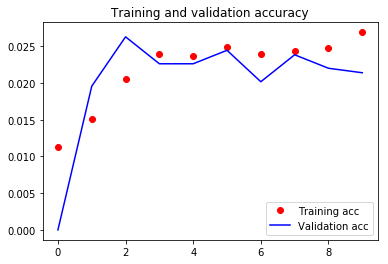

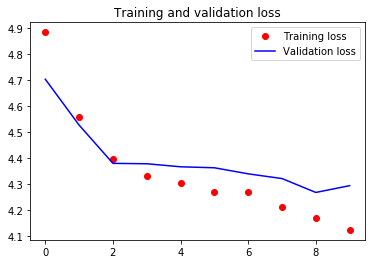

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
model.save('vgg16_10epochs.h5')

## Final Model Evaluation

In [31]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=103)
y_hat_test = model.predict_generator(test_generator, steps=103)
print(f'Generated {len(y_hat_test)} predictions')
print(f'Test Accuracy: {test_acc}')

Generated 2045 predictions
Test Accuracy: 0.02738386356160227


In [32]:
t1 = datetime.datetime.now()
print(f'Time to Complete: {t1-t0}')

Time to Complete: 6:25:17.406324


## Summary

Congratulations! In this lab, you brought all of your prior deep learning skills together from preprocessing including one-hot encoding, to adapting a pretrained model. There are always ongoing advancements in CNN architectures and best practices, but you have a solid foundation and understanding at this point.